# Recurrent Neural Network Homework

This is the 4th assignment for CAP 4630 and we will implement a basic RNN network and an LSTM network with Pytorch to solve two problems. \
You will use **"Tasks"** and **"Hints"** to finish the work. **(Total 60 points, with extra 10 bonus points)** \
You may use Machine Learning libaries like Scikit-learn for data preprocessing.

**Task Overview:**
- Implement a basic RNN network to solve time series prediction
- Implement an LSTM network to conduct sentiment analysis

## 1 - Implement a RNN model to predict time series##
### 1.1 Prepare the data (10 Points)

Prepare time series data for deep neural network training.

**Tasks:**
1. Load the given train and test data: "train.txt" and "test.txt". **(2.5 Points)**
2. Generate the **TRAIN** and **TEST** labels. **(2.5 Points)**
3. Normalize the **TRAIN** and **TEST** data with sklearn function "MinMaxScaler". **(2.5 Points)**
4. **PRINT OUT** the **TEST** data and label. **(2.5 Points)**

**Hints:**  
1. The length of original train data is 113 which starts from **"1949-01"** to **"1958-05"**. The length of original test data is 29, which starts from **"1958-07"** to **"1960-11"**.
2. Set the data types of both train and test data to "float32".
3. Use **past 12** datapoints as input data X to predict the **next 1** datapoint as Y, which is the 'next token prediction'. The time window will be 12.
4. The first 3 **TRAIN** data and label should be:

- trainX[0] = [[0.02203858 &nbsp; 0.03856748 &nbsp; 0.077135 &nbsp;  0.06887051 &nbsp; 0.04683197 &nbsp; 0.08539945 &nbsp; 0.12121212 &nbsp; 0.12121212 &nbsp; 0.08815429 &nbsp; 0.04132232 &nbsp; 0.    &nbsp; 0.03856748]]
- trainY[0] = [0.03030303]

- trianX[1] = [[0.03856748 &nbsp; 0.077135 &nbsp;  0.06887051 &nbsp; 0.04683197  &nbsp; 0.08539945  &nbsp; 0.12121212  &nbsp; 0.12121212  &nbsp; 0.08815429  &nbsp; 0.04132232  &nbsp; 0.     &nbsp;  0.03856748   &nbsp; 0.03030303]]
- trainY[1] = [0.06060606]

- trainX[2] =  [[0.077135 &nbsp;  0.06887051 &nbsp; 0.04683197 &nbsp; 0.08539945 &nbsp; 0.12121212 &nbsp; 0.12121212 &nbsp; 0.08815429 &nbsp; 0.04132232 &nbsp; 0.    &nbsp;     0.03856748 &nbsp; 0.03030303 &nbsp; 0.06060606]]
- trainY[2] = [0.10192838]

5. Apply the MinMaxScaler to both the train and test data.\
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [127]:
"""

https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch
https://medium.com/dejunhuang/learning-day-27-implementing-rnn-in-pytorch-for-time-series-prediction-3ddb6190e83d
"""

'\n\nhttps://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch\nhttps://medium.com/dejunhuang/learning-day-27-implementing-rnn-in-pytorch-for-time-series-prediction-3ddb6190e83d\n'

In [128]:
# Import Packages

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization 
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable


# Set up for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [129]:
# Import Dataset

train_dataset = pd.read_csv('data/train-1.csv', usecols=['Month','Passengers'])
test_dataset = pd.read_csv('data/test-1.csv', usecols=['Month','Passengers'])

print(train_dataset.head())
print(test_dataset.head())

     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121
     Month  Passengers
0  1958-07         491
1  1958-08         505
2  1958-09         404
3  1958-10         359
4  1958-11         310


In [130]:
# Preprocess Dataset
# Convert type of values to float

import datetime as dt

train_dataset['Month'] = train_dataset['Month'].str.replace('-','')
test_dataset['Month'] = test_dataset['Month'].str.replace('-','')


train_dataset["Month"] = pd.to_numeric(train_dataset["Month"], downcast="float")
test_dataset["Month"] = pd.to_numeric(test_dataset["Month"], downcast="float")
train_dataset["Passengers"] = pd.to_numeric(train_dataset["Passengers"], downcast="float")
test_dataset["Passengers"] = pd.to_numeric(test_dataset["Passengers"], downcast="float")


print(train_dataset.head())
print("\n")
print(test_dataset.head())
print("\n")

print("Training Dataset Shape: ", train_dataset.shape)
print("Test Dataset Shape: ", test_dataset.shape)

      Month  Passengers
0  194901.0       112.0
1  194902.0       118.0
2  194903.0       132.0
3  194904.0       129.0
4  194905.0       121.0


      Month  Passengers
0  195807.0       491.0
1  195808.0       505.0
2  195809.0       404.0
3  195810.0       359.0
4  195811.0       310.0


Training Dataset Shape:  (113, 2)
Test Dataset Shape:  (29, 2)


In [131]:
# Preprocess Data

# Normalize data:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

train_dataset = normalize(train_dataset)
test_dataset = normalize(test_dataset)



In [132]:
# Reshape from 2D to 1D array
train_dataset =np.reshape(train_dataset,(-1,1))
test_dataset=np.reshape(test_dataset,(-1,1))


In [133]:
# Apply Min Max Scalar
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(train_dataset)
 
print(scaled_train[:5])
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(test_dataset)
print(scaled_test[:5]) #prints the first 5 rows

[[0.        ]
 [0.02203857]
 [0.00110619]
 [0.03856749]
 [0.00221239]]
[[0.        ]
 [0.5801282 ]
 [0.00490196]
 [0.625     ]
 [0.00980392]]


In [134]:
# Create sequences and labels for training data
sequence_length = 12  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)
 
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape





(torch.Size([214, 12, 1]), torch.Size([214, 12, 1]))

In [135]:
# Create sequences and labels for testing data
sequence_lenth = 12  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)
 
# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([46, 12, 1]), torch.Size([46, 12, 1]))

In [136]:
# Create Dataloaders

batch_size = 1
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 
# Create DataLoader for batch training
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 1.2 - Build the RNN model (20 Points) ##


Build a RNN model with RNN cell.

**Tasks:**
1. Build an RNN model with 1 RNN layer and 1 Linear layer, with RNN's hidden size to be 4.  **(10 Points)**
2. Initialize model, optimizer and criterion. **(5 Points)**
3. Train the model for **1000** epochs with **batch_size = 10** and **print out the average traning loss for every 100 epochs**. **(5 Points)**

**Hints:**  
1. You can use **nn.RNN** to specify RNN cells.
2. Use loss function (criterion) **MSELoss()** and select **Adam** optimizer with **learning_rate=0.005** and other default settings.

In [137]:
# number of points
num_time_steps = 113
hidden_size = 4
input_size = 1
output_size = 1
lr = 0.005
num_epochs = 1000


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            # use batch_first for input with another data shape with b first
        )
        # compress output to the same dim as y
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_prev):
        out, hidden_prev = self.rnn(x, hidden_prev)
        # [1, seq, h] => [seq, h]  (batch=1)
        out = out.reshape(-1, hidden_size)  # stack batch and seq

        # linear layer so that output is not [seq,h] but [seq, 1]
        # so it is comparable with y, for loss calculation
        out = self.linear(out)  # [seq, h] => [seq, 1]
        out = out.unsqueeze(dim=0)  # => [1, seq, 1]
        return out, hidden_prev

model = Net().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

hidden_prev = torch.zeros(1, 1, hidden_size).to(device)  # [b, layer, mem_size]




In [139]:
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
 
    # Training
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)


        predictions,hidden_prev = model(batch_X,hidden_prev)
        hidden_prev = hidden_prev.detach()
        
        loss = criterion(predictions, batch_y)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_loss += loss.item()
 
    # Calculate average training loss and accuracy
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)
 
    # Validation on test data
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0
 
        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test,hidden_prev = model(batch_X_test,hidden_prev)
            test_loss = criterion(predictions_test, batch_y_test)
 
            total_test_loss += test_loss.item()
 
        # Calculate average test loss and accuracy
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)
    if (epoch+1)%10==0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [10/1000] - Training Loss: 0.0101, Test Loss: 0.0456
Epoch [20/1000] - Training Loss: 0.0082, Test Loss: 0.0411
Epoch [30/1000] - Training Loss: 0.0069, Test Loss: 0.0440
Epoch [40/1000] - Training Loss: 0.0070, Test Loss: 0.0454
Epoch [50/1000] - Training Loss: 0.0068, Test Loss: 0.0485
Epoch [60/1000] - Training Loss: 0.0066, Test Loss: 0.0518
Epoch [70/1000] - Training Loss: 0.0065, Test Loss: 0.0581
Epoch [80/1000] - Training Loss: 0.0069, Test Loss: 0.0524
Epoch [90/1000] - Training Loss: 0.0064, Test Loss: 0.0549
Epoch [100/1000] - Training Loss: 0.0064, Test Loss: 0.0589
Epoch [110/1000] - Training Loss: 0.0065, Test Loss: 0.0512
Epoch [120/1000] - Training Loss: 0.0067, Test Loss: 0.0610
Epoch [130/1000] - Training Loss: 0.0064, Test Loss: 0.0576
Epoch [140/1000] - Training Loss: 0.0063, Test Loss: 0.0617
Epoch [150/1000] - Training Loss: 0.0056, Test Loss: 0.0639
Epoch [160/1000] - Training Loss: 0.0063, Test Loss: 0.0624
Epoch [170/1000] - Training Loss: 0.0062, Test Lo

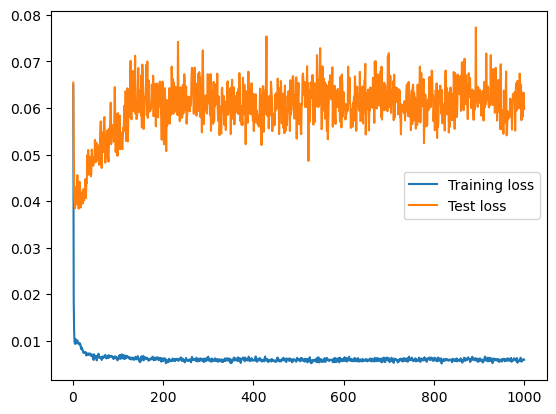

In [140]:
# Plot the learning curve

x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()